In [9]:
%load_ext autoreload
import sys
sys.path.append("../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%matplotlib inline

In [11]:
%autoreload

import matplotlib
matplotlib.rc_file('../matplotlibrc')
import matplotlib.pyplot as plt
import pickle

import numpy as np
from scipy.interpolate import interp1d

import darkhistory.physics as phys
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
import main

In [12]:
from config import load_data
from darkhistory.spec.spectrum import Spectrum
import darkhistory.spec.spectools as spectools
binning = load_data('binning')

In [13]:
from tqdm import tqdm_notebook as tqdm
from scipy.integrate import solve_ivp

In [711]:
def delta_distortion(nmax, rs, x_nl, BB, photeng, dlnz, 
    include_2s = True, spec_2s1s = None, 
    include_cont = True, T_m = None, xHII = None
):

    # It is best not to recompute spec_2s1s every time, for efficiency purposes
    if(include_2s and spec_2s1s == None):
        raise TypeError('Please provide spec_2s1s')

    num_states = (int) (nmax*(nmax+1)/2)
    states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
    states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])

    def E(n): return phys.rydberg/n**2
    nH = phys.nH * rs**3
    nB = phys.nB * rs**3

    dt = dlnz/phys.hubble(rs)

    #initialize
    E_current = 0
    ind_current = 0
    H_engs = np.zeros(num_states)
    Nphot_cascade = np.zeros(num_states) # List containing bound-bound photon count
    BF_spec = Spectrum(photeng, np.zeros_like(photeng), spec_type='dNdE') # Spectrum to contain bound-free photons    
    

    for nl in np.arange(num_states):
        n = states_n[nl]
        l = states_l[nl]

        # If this state has a new energy, add to the list of photon energies
        # Add nmax-n more indices, you'll end up with nmax(nmax-1)/2
        if E_current != E(n):

            #Start by filling from 0 to nmax-1
            if n>1: ind_current += nmax-n+1

            E_current = E(n)
            H_engs[ind_current:ind_current + nmax-n] = E(n)-E(np.arange(n+1,nmax+1))

        #note: 'dn' and 'up' have nothing to do with down- or up-scattering, 
        # just if the l quantum number go up or down

        # photons from l <-> l+1 transitions
        if l<nmax-1:
            # Number of photons injected per baryon
            Nphot_cascade[ind_current:ind_current + nmax-n] += nH*(
                x_nl[(states_l == l+1) * (states_n>n)] * BB['dn'][n+1:,n,l+1] #Downscattering adds photons
                -x_nl[nl] * BB['up'][n,n+1:,l] #upscattering subtracts them
            )/nB * dt
        
        # photons from l <-> l-1 transitions
        if l>0:
            Nphot_cascade[ind_current:ind_current + nmax-n] += nH * ( 
                x_nl[(states_l == l-1) * (states_n>n)] * BB['up'][n+1:,n,l-1] #Downscattering
                -x_nl[nl] * BB['dn'][n,n+1:,l] #upscattering
            )/nB * dt

        # Add the bound-free component
        if include_cont:
            tmp = nH**2 * xHII**2 * bf.gamma_nl(
                n, l, T_m, T_r=phys.TCMB(rs), f_gamma=None, stimulated_emission=True
            )/nB * dt
            tmp -= nH * x_nl[nl] * bf.xi_nl(n, l, T_r=phys.TCMB(rs), f_gamma=None)/nB * dt
            tmp.rebin(photeng)
            BF_spec.dNdE += tmp.dNdE
        
            
    # Make a spectrum
    data = sorted(np.flipud(np.transpose([H_engs,Nphot_cascade])), key=lambda pair:pair[0])

    # Consolidate duplicates (e.g. 6 <-> 9 transition is same energy as 8 <-> 72)
    i = 0
    sz = num_states
    while i<sz-1:
        while (i < sz-1) and (data[i][0]==data[i+1][0]):
            data[i][1] += data[i+1][1]
            data.pop(i+1)
            sz -= 1

        i += 1

    data = np.array(data)

    transition_spec = Spectrum(data[:,0], data[:,1], spec_type='N', rs=rs)
    transition_spec.rebin(photeng)

    # Add the bound-free photons
    BF_spec.rebin(photeng)
    transition_spec.N += BF_spec.N
        
    # Add the two photon transitions
    if include_2s:
        
        #!!! Tm or Tr in detailed balance?
        amp_2s1s = nH * BB['dn'][2,1,0] * (x_nl[1] - x_nl[0]*np.exp(-phys.lya_eng/phys.TCMB(rs))) / nB * dt

        transition_spec.N += amp_2s1s * spec_2s1s.N

    return transition_spec

In [723]:
%autoreload

from darkhistory.spec.spectra import Spectra

nmax=10
include_2s = True
include_cont = True

skip=1

hplanck = phys.hbar * 2*np.pi
def Delta_f(E): return 0
def g_nl(l): return 2*l +1
def E(n): return phys.rydberg/n**2
hc = 2*np.pi*phys.hbar * phys.c

dlnz = .001
rs_vec  = hyrec100['rs']
# rs_vec  = np.exp(np.arange(np.log(5e2),np.log(3.5e3),dlnz))
Tr_vec  = phys.TCMB(rs_vec)
# Tm_vec  = phys.Tm_std(rs_vec)
Tm_vec = Tr_vec.copy()

length  = len(rs_vec)

xe_vec  = phys.xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)

nH_vec  = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec


# eng = binning['phot']
eng = np.exp(np.linspace(np.log(hplanck*1e8), np.log(phys.rydberg), 500))
# eng = np.linspace(hplanck*1e8, phys.rydberg, 10000)
if include_2s:
    spec_2s1s = spectools.discretize(eng, phys.dNdE_2s1s)

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

H_engs = atomic.get_transition_energies(nmax)
num_lines = H_engs.size-1

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
# x_lte = np.zeros(num_states) #equilibrium solution
# x_lte[0] = x1s_vec[0]

beta_MLA = np.zeros(length)
alpha_MLA = np.zeros(length)
greg_2s = np.zeros(length)
greg_2p = np.zeros(length)

new_switch = True

#Store the distortion here
if nmax == 10:          distortion10  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
elif nmax == 20:        distortion20  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
elif nmax == 30:               
    if not include_2s:  distortion30  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
    else:               full_dist  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
else: 
    other_dist  = Spectrum(eng, np.zeros_like(eng), spec_type='N', rs=1)
delta_dists = Spectra(np.zeros((len(rs_vec), len(eng))), eng=eng, spec_type='N', rs=rs_vec)

for i in tqdm(np.arange(0,length,skip)):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    x2s = x2s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    # k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, Delta_f=Delta_f, stimulated_emission=True)
    beta = atomic.populate_beta(Tr, nmax, Delta_f=Delta_f)

    #Include sobolev optical depth
    for n in range(2,nmax+1):
        BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
        BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

    ### Build matrix K_ij = R_ji/R_i,tot and inhomogeneous term ###
    K = np.zeros((num_states, num_states))
    b = np.zeros(num_states)
    for nl in np.arange(num_states):
        # Find indices for possible states to transition to (l must change by 1)
        # Get the rates for transitioning to those states, as well as total rate

        n = states_n[nl]
        l = states_l[nl]
        # x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x2s
        tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
        
        # Construct the matrix
        if l!= 0:
            K[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
            
        if l!= nmax-1:
            K[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

        # Special 2s->1s transition
        if nl == 0:
            K[0][1] = BB['dn'][2][1][0]/ tot_rate
        if nl == 1:
            #Detalied Balance
            K[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
            

        # Construct the inhomogeneous term
        b[nl] += xe**2 * nH * alpha[n][l]
        if l==1:
            b[nl] += x1s*BB['up'][1, n, 0]
        elif nl==1:
            # 1s to 2s transition from detailed balance
            b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
            
        b[nl] /= tot_rate

    #Probability matrix for only the excited states
    M = ident - K[1:,1:]
    
    x_vec[i] = np.linalg.solve(M,b[1:])
    # x_full = np.append(1-np.sum(x_vec[i])-xe, x_vec[i])
    x_full = np.append(x1s, x_vec[i])
    
    for nl in np.arange(num_states):
        n, l = states_n[nl], states_l[nl]
        if nl > 0:
            beta_MLA[i]  += x_full[nl] * beta[n][l]
            alpha_MLA[i] += alpha[n][l] #* xe**2 * nH

    transition_spec = delta_distortion(nmax, rs_vec[i], x_full, BB, eng, dlnz, 
        include_2s = include_2s, spec_2s1s=spec_2s1s,
        include_cont = include_cont, T_m = Tm, xHII = xe
    )
    delta_dists._grid_vals[i] = transition_spec.N
    transition_spec.redshift(1)
    
    greg_2s[i] = nH * BB['dn'][2,1,0] * (x_full[1] - x_full[0]*np.exp(-phys.lya_eng/phys.TCMB(rs)))
    greg_2p[i] = nH * (BB['dn'][2,1,1] * x_full[2] - BB['up'][1,2,0] * x_full[0])

    if nmax == 10:          distortion10.N += transition_spec.N
    elif nmax == 20:        distortion20.N += transition_spec.N
    elif nmax == 30:            
        if not include_2s:  distortion30.N += transition_spec.N
        else:               full_dist.N    += transition_spec.N
    else:                   other_dist.N    += transition_spec.N

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_2289/42409190.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(0,length,skip)):


  0%|          | 0/34 [00:00<?, ?it/s]

In [738]:
%autoreload
MLA_funcs = pickle.load(open('/Users/gregoryridgway/Desktop/Data/MLA_funcs_100.p','rb'))
nmax=10
start_rs=3e3
end_rs = 2.9e3

hyrec100 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=1, backreaction=False, 
    distort=True, fudge=True,
    end_rs=end_rs, nmax=nmax,
    MLA_funcs=MLA_funcs, cross_check=True
)

cross_check has been set to True -- No longer using all MEDEA files and no longer using partial-binning.


  0%|          | 0/34.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../main.py:560: RuntimeWarning: invalid value encountered in log
  np.log(beta_MLA_data[:,1]),  fill_value='extrapolate'


In [739]:
print(hyrec100['distortion'].toteng(), distortion10.toteng())

-8.648072210810539e-16 -8.648072210810539e-16


In [669]:
np.all(Tm_vec/hyrec100['Tm']) and np.all((1-xe_vec)/(1-hyrec100['x'][:,0]))

True

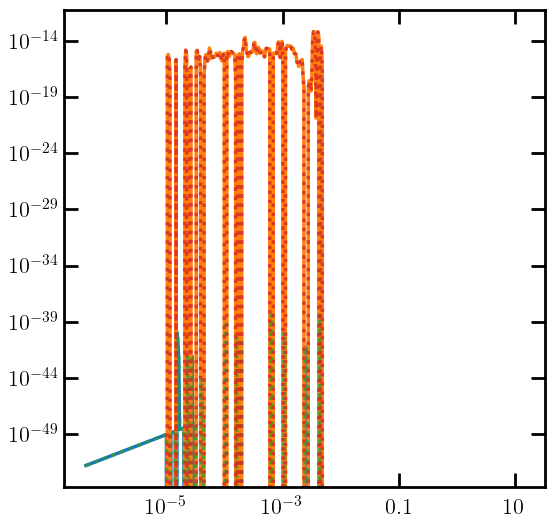

In [740]:
plt.figure()
plt.loglog()
# plt.plot(distortion10.eng, (distortion10.N+inc)/(hyrec100['distortion'].N+inc))

plt.plot(hyrec100['distortion'].eng, convert * hyrec100['distortion'].dNdE)
plt.plot(hyrec100['distortion'].eng, -hyrec100['distortion'].N)
plt.plot(distortion10.eng, convert * distortion10.dNdE, alpha=0.8, linestyle=':')
plt.plot(distortion10.eng, -distortion10.N, alpha=0.8, linestyle=':')

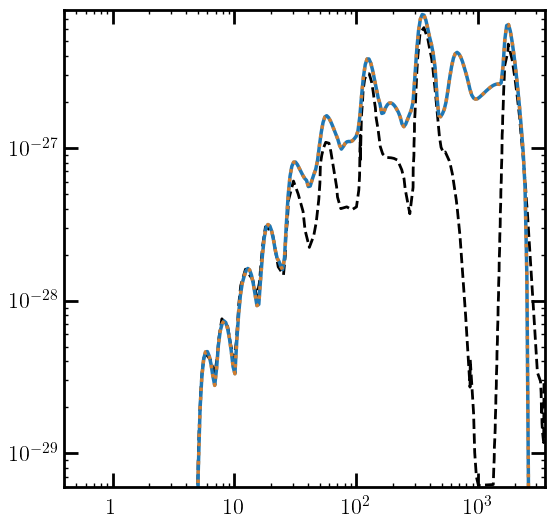

In [720]:
# Discrepancy in tail comes from amp_2s1s discrepancy.  
# Same input to operations, different output. Python issue?

plt.figure()
plt.loglog()
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(distortion10.eng, (distortion10.N+inc)/(hyrec100['distortion'].N+inc))

planck = phys.hbar * 2*np.pi
convert = phys.nB * hyrec100['distortion'].eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = hyrec100['distortion'].eng/hplanck
plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')

plt.plot(nu/1e9, convert * hyrec100['distortion'].dNdE)
# plt.plot(hyrec100['distortion'].eng, -hyrec100['distortion'].N)
plt.plot(nu/1e9, convert * distortion10.dNdE, alpha=0.8, linestyle=':')
# plt.plot(distortion10.eng, -distortion10.N, alpha=0.8, linestyle=':')

### Try cosmological parameters

In [ ]:
# phys.omega_m = 0.2678
# phys.omega_baryon = 0.0444
# phys.h = 0.71
# phys.omega_lambda = 0.7322
# phys.YHe = 0.24

Text(0.5, 0, 'Redshift, $1+z$')

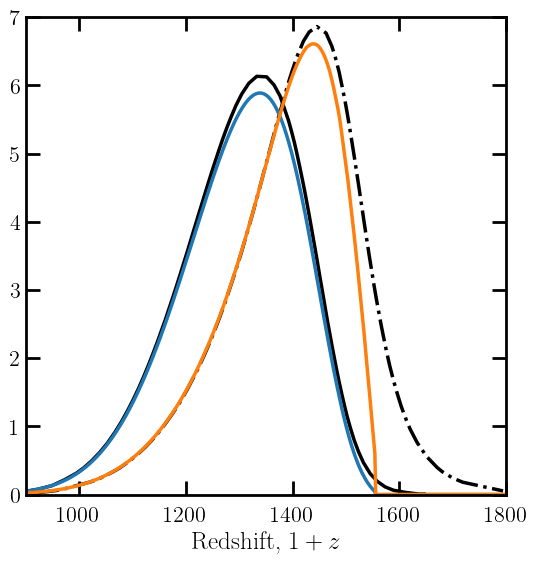

In [ ]:
plt.figure()

plt.axis([900,1800,0,7])
plt.plot(jens_2s[:,0], jens_2s[:,1], color='k')
plt.plot(jens_2p[:,0], jens_2p[:,1], linestyle='dashdot', color='k')

plt.plot(rs_vec, 1e11*greg_2s)
plt.plot(rs_vec, 1e11*greg_2p)
# plt.axvline(1.5e3, color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$')
# plt.ylabel(r'Distortion Energy Injected, $\Delta \epsilon_{inj}/n_B$')

Text(0, 0.5, 'Distortion Energy Injected, $\\Delta \\epsilon_{inj}/n_B$')

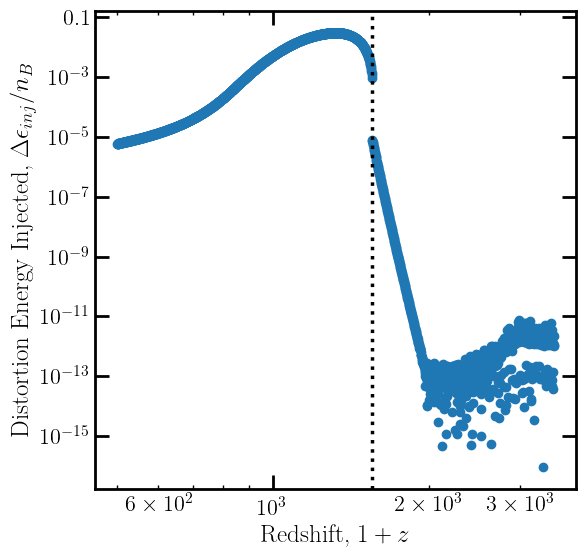

In [ ]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(1.555e3, color='k', linestyle=':')
# plt.axvline(1.5e3, color='k', linestyle=':')
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Distortion Energy Injected, $\Delta \epsilon_{inj}/n_B$')

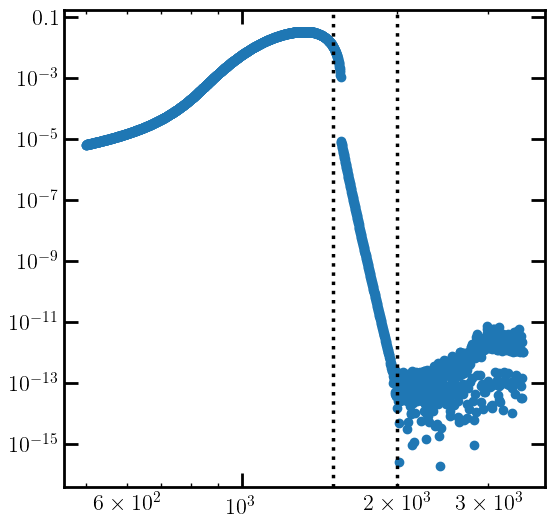

In [547]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

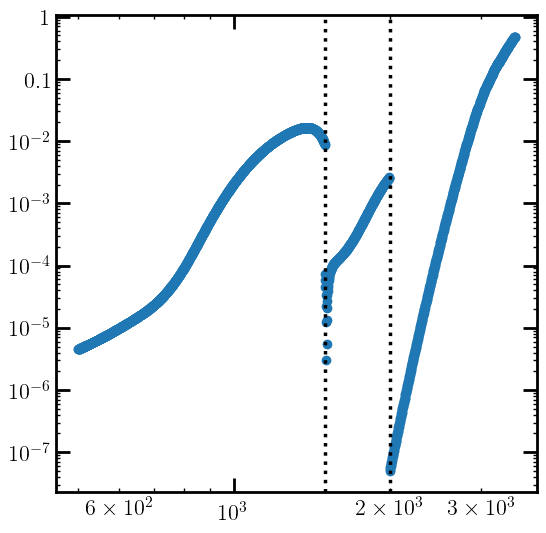

In [ ]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

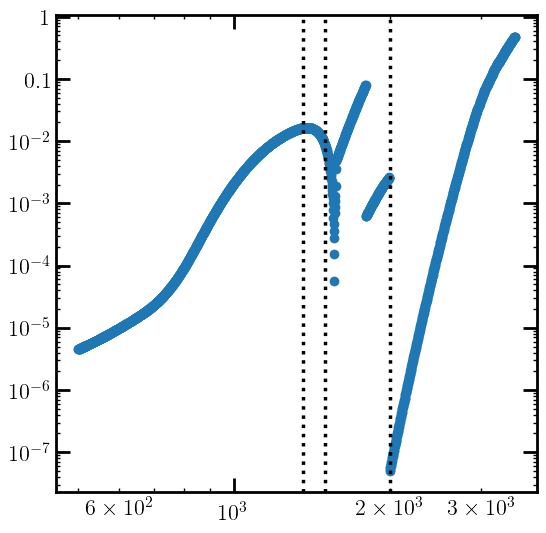

In [ ]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

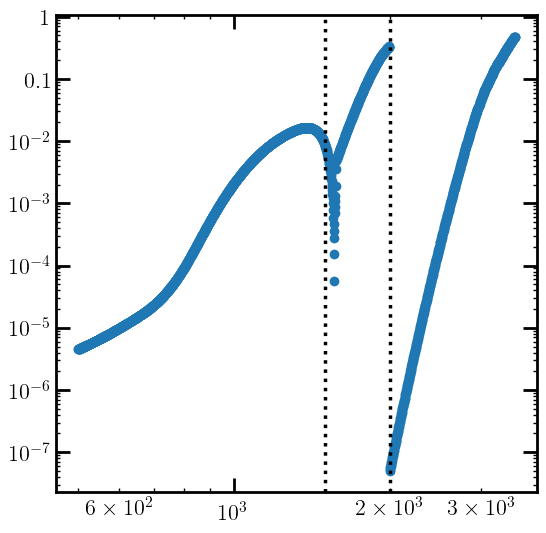

In [ ]:
plt.figure()

plt.loglog()
plt.scatter(delta_dists.rs, np.abs(delta_dists.toteng()))
plt.axvline(2e3, color='k', linestyle=':')
plt.axvline(1.5e3, color='k', linestyle=':')

# plt.xscale('log')
# plt.xlim([H_engs[0]/2, H_engs[-1]*1.1])
# plt.plot(delta_dists.eng, delta_dists[1].N)
# plt.plot(delta_dists.eng, delta_dists[120].N, alpha=0.5)


In [ ]:
import csv

def download_plot(file):
    with open('/Users/gregoryridgway/Desktop/Webplot_distortion/'+file+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        goods = []
        for row in reader:
            goods.append([float(r) for r in row])
            
        goods = np.array(goods)

    return goods

n10_data = download_plot('n10')
n20_data = download_plot('n20')
n30_data = download_plot('n30')
jens_data = download_plot('Full_Distortion')
jens_2s = download_plot('DeltaR_2s_jens')
jens_2p = download_plot('DeltaR_2p_jens')
BB_BF_jens = download_plot('BB_plus_BF_dist')


Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

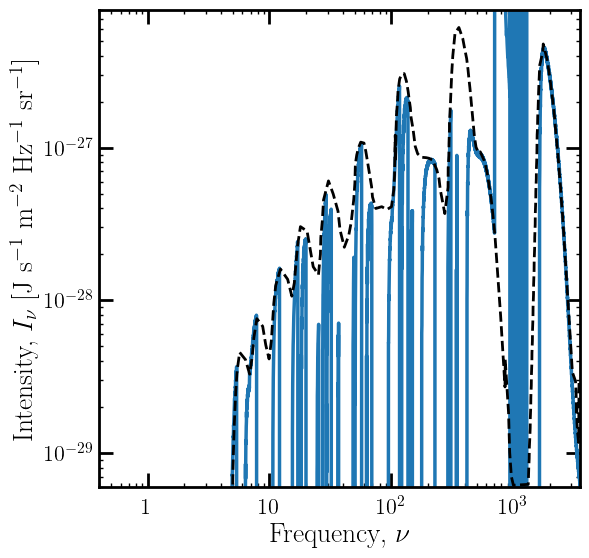

In [ ]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE)
# plt.scatter(nu/1e9, convert * distortion20.dNdE, s=1)
# plt.scatter(nu/1e9, convert * distortion30.dNdE, s=1)

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

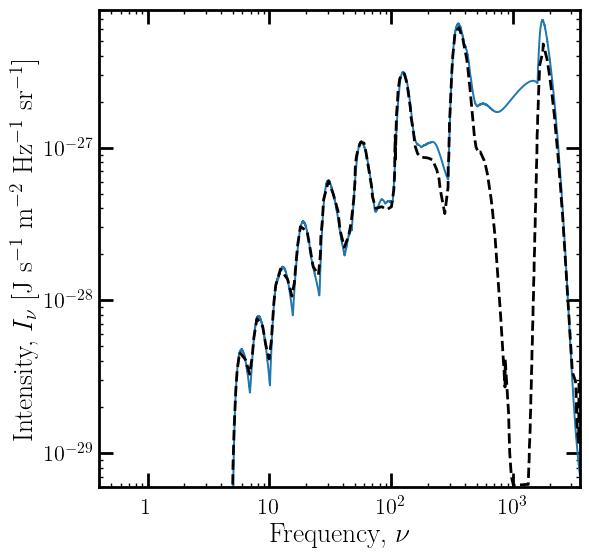

In [ ]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
# plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

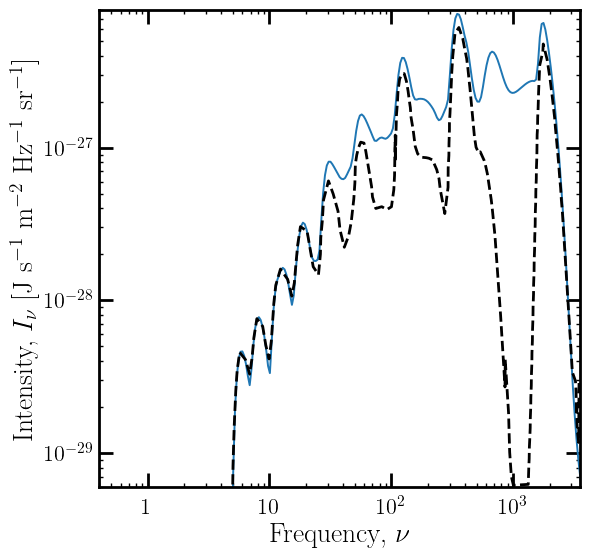

In [548]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
# plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

In [ ]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
# plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
# plt.plot(n30_data[:,0], n30_data[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

Text(0, 0.5, 'Intensity, $I_{\\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]')

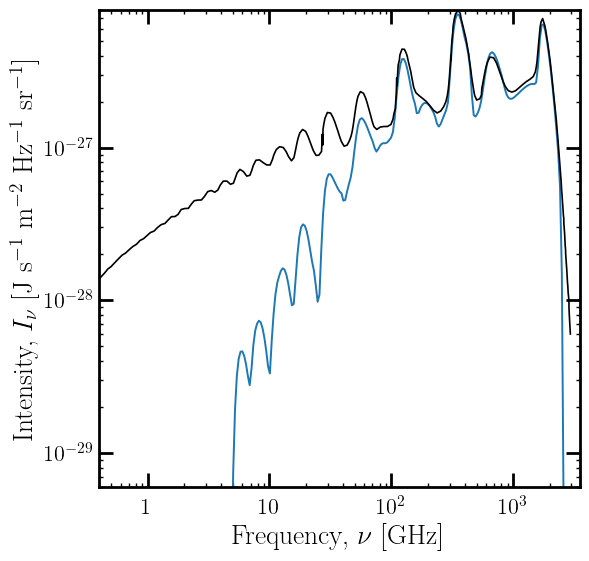

In [365]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
# plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
# plt.plot(nu/1e9, convert * full_dist.dNdE, linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

ValueError: operands could not be broadcast together with shapes (100,) (500,) 

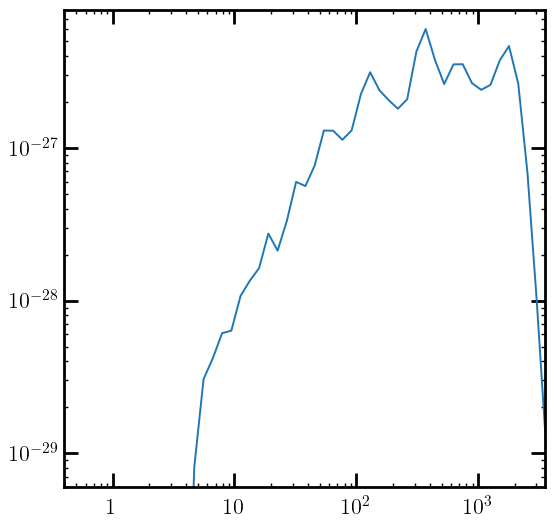

In [233]:
planck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300


plt.figure()
# plt.xscale('log')
plt.loglog()
# plt.axis([1e-3,1,-1.4e-7,1e-8])
plt.xlim([4e-1, 3.5e3])
plt.ylim([6e-30, 8e-27])
# plt.plot(nu_coarse[::100]/1e9, data_coarse)
plt.plot(nu/1e9, convert * distortion10.dNdE, linewidth=1.4)
# plt.plot(nu/1e9, convert * distortion10.dNdE*1.2, linewidth=1.4, linestyle=':', color='k')
# plt.plot(nu/1e9, convert * distortion20.dNdE, linewidth=1.4, color='C2')
plt.plot(nu/1e9, convert * full_dist.dNdE[::10], linewidth=1.7, color='C3')
# plt.plot(nu/1e9, convert * distortion30.dNdE, linewidth=1.7)

# # plt.axvline(-13.6*(1/3**2 - 1/2**2)/hplanck/1400/1e9, color='red', linestyle=':')
# plt.axvline(4.4/hplanck/rs_fac/1e9, color='red', linestyle=':')

# #2p-1s
# plt.axvline(13.6*(1**-2 - 2**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #3p-2s
# plt.axvline(13.6*(2**-2 - 3**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# #4p-3s
# plt.axvline(13.6*(3**-2 - 4**-2)/hplanck/rs_fac/1e9, color='green', linestyle=':')

# plt.plot(n10_data[:,0], n10_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(n20_data[:,0], n20_data[:,1], color='k', linewidth=1.0, linestyle=':')
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k', linewidth=1.2)
# plt.plot(jens_data[:,0], jens_data[:,1], color='k', linewidth=2.0, linestyle='--')
# plt.plot(distortion30.eng/hplanck/1e9, convert * distortion30.dNdE)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

- Look for more recent results
- Ask Jens

$$
4\mathcal{C} \beta_B x_{1s} e^{-E_\alpha /T} = \beta_{MLA}
$$

In [ ]:
ion_TLA = np.zeros(length)
ion_Hongwan_noSE = np.zeros(length)
ion_Hongwan = np.zeros(length)
# nmax = 20

for i,Tr in enumerate(tqdm(rs_vec)):
    rs = rs_vec[i]
    x2 = x2_vec[i]
    Tr = Tr_vec[i]
    
    ion_TLA[i] = phys.beta_ion(Tr,'HI') * x2
    
    #Detailed Balance factor
    lam_T = hc/np.sqrt(2*np.pi*phys.mu_ep*Tr)
    db_fac = np.exp(phys.rydberg/4 / Tr) * lam_T**3 * 4
    ion_Hongwan_noSE[i] = bf.alpha_B(Tr, T_r=Tr, stimulated_emission=False, f_gamma=None, n=nmax)/db_fac * x2
    
    ion_Hongwan[i] = bf.beta_B(Tr,nmax) * x2
    
#     print(rs, " Done")

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_4224/37483958.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,Tr in enumerate(tqdm(rs_vec)):


  0%|          | 0/355 [00:00<?, ?it/s]

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_4224/37483958.py:15: RuntimeWarning: overflow encountered in exp
  db_fac = np.exp(phys.rydberg/4 / Tr) * lam_T**3 * 4


/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_4224/976435076.py:22: RuntimeWarning: divide by zero encountered in true_divide
  axarr[1].plot(rs_vec[rs_vec>700], (beta_MLA/ion_TLA-1)[rs_vec>700],


Text(0.5, 1.0, 'Residuals')

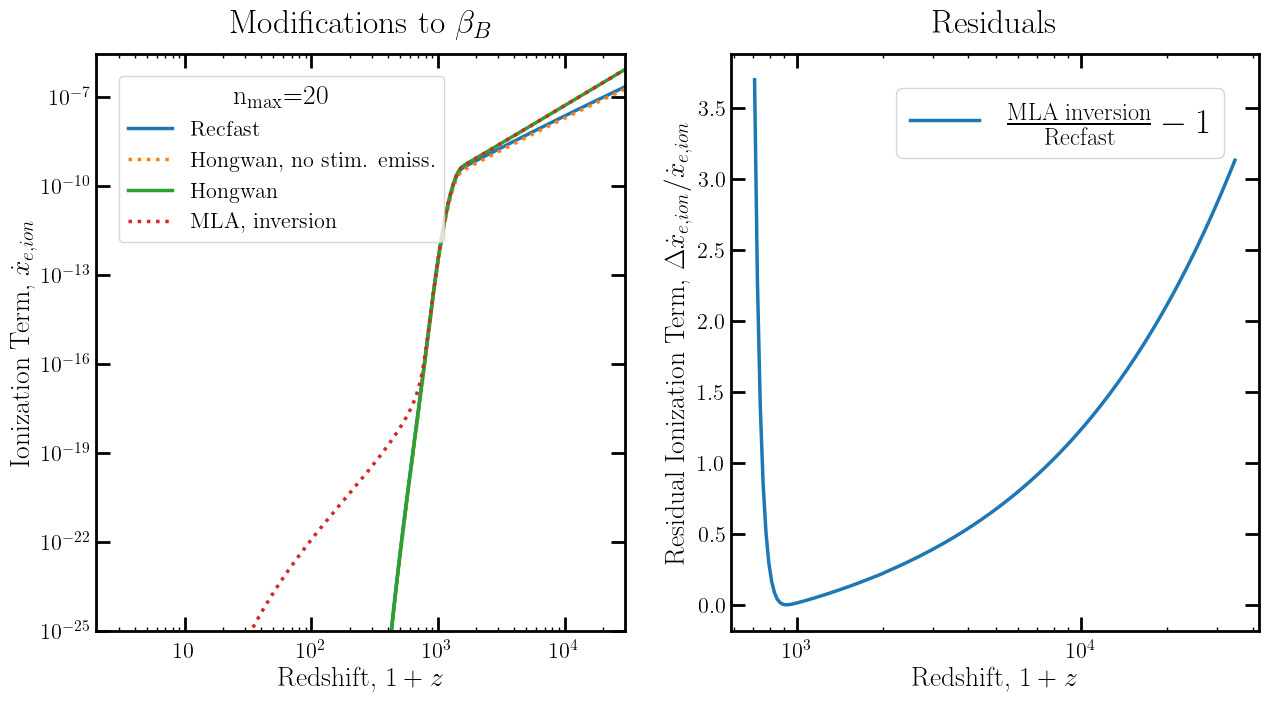

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(2*7.5, 7.5))

axarr[0].loglog()
axarr[0].axis([2,3e4,1e-25,3e-6])
# plt.axis([5e2,2e4,1e-17,10])

axarr[0].plot(rs_vec,ion_TLA, label='Recfast')
axarr[0].plot(rs_vec,ion_Hongwan_noSE, label='Hongwan, no stim. emiss.', linestyle=':')
axarr[0].plot(rs_vec,ion_Hongwan, label='Hongwan')
axarr[0].plot(rs_vec,beta_MLA, label='MLA, inversion', linestyle=':')

axarr[0].legend(fontsize=12)
axarr[0].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[0].set_ylabel(r'Ionization Term, $\dot{x}_{e,ion}$', fontsize=20)
axarr[0].legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

axarr[0].set_title(r'Modifications to $\beta_B$')



axarr[1].set_xscale('log')
axarr[1].plot(rs_vec[rs_vec>700], (beta_MLA/ion_TLA-1)[rs_vec>700], 
              label=r'$\frac{\mathrm{MLA \; inversion}}{\mathrm{Recfast}}-1$')

axarr[1].legend(fontsize=25)
axarr[1].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[1].set_ylabel(r'Residual Ionization Term, '+
                    r'$\Delta \dot{x}_{e,ion}/\dot{x}_{e,ion}$', fontsize=20)

axarr[1].set_title(r'Residuals')

Text(0.5, 1.0, 'Modifications to $\\alpha_B$')

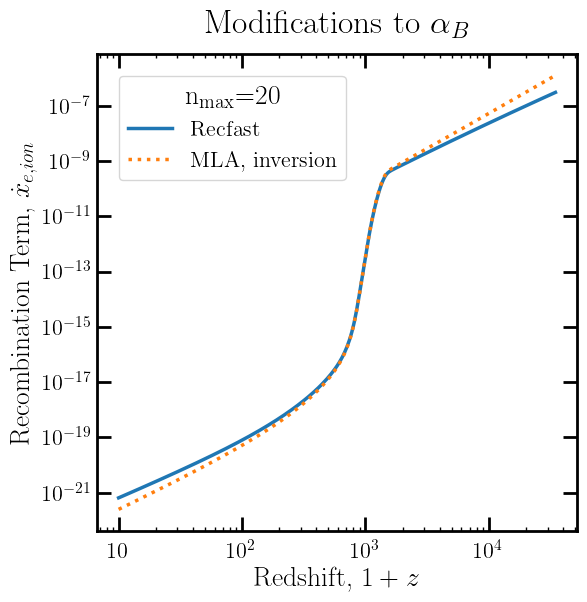

In [ ]:
plt.figure()
plt.loglog()
# plt.axis([2,3e4,1e-25,3e-6])
# plt.axis([5e2,2e4,1e-17,10])

plt.plot(rs_vec,phys.alpha_recomb(Tm_vec,'HI')*nH_vec*xe_vec**2, label='Recfast')
# plt.plot(rs_vec,ion_Hongwan_noSE, label='DH, no stim. emiss.')
# plt.plot(rs_vec,ion_Hongwan, label='DH')
plt.plot(rs_vec,alpha_MLA * xe_vec**2 * nH_vec, label='MLA, inversion', linestyle=':')

plt.legend()
plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Recombination Term, $\dot{x}_{e,ion}$', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Modifications to $\alpha_B$')

### Understanding the output Distortion

### Recovering the TLA Assumptions

Text(0.5, 1.0, 'Testing the TLA Assumptions')

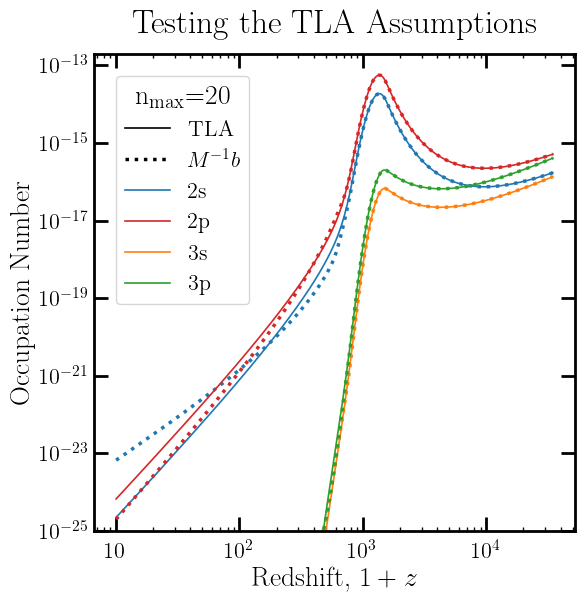

In [ ]:
plt.figure()
plt.loglog()
plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=1.2

plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), label=r'$M^{-1} b$', color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec, label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,0], color='C0', linestyle=':')

plt.plot(rs_vec, 3*x2s_vec, label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,1], color='C3', linestyle=':')

plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

Text(0.5, 1.0, 'Testing the TLA Assumptions')

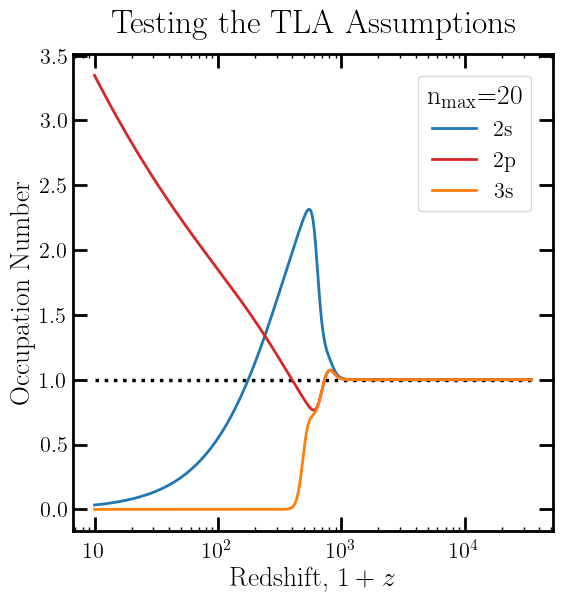

In [ ]:
plt.figure()
# plt.loglog()
plt.xscale('log')
# plt.ylim([1e-25,2e-13])

x2s_vec = x2_vec/4

# plt.plot(rs_vec, xe_vec*1e-13, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)
# plt.plot(rs_vec, Tm_vec*1e-14, label=r'$x_e \times 10^{-13}$', color='k', linewidth=1.0)

lw=2.0

# plt.plot(rs_vec, np.ones_like(rs_vec), label=r'TLA', color='k', linewidth=lw)
plt.plot(rs_vec, np.ones_like(rs_vec), color='k', linestyle=':')

plt.plot(rs_vec, x2s_vec/x_vec[:,0], label='2s', color='C0', linewidth=lw)
plt.plot(rs_vec, 3*x2s_vec/x_vec[:,1], label='2p', color='C3', linewidth=lw)
plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec)/x_vec[:,2], 
         label='3s', color='C1', linewidth=lw)


# plt.plot(rs_vec, g_nl(0)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3s', color='C1', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,2], color='C1', linestyle=':')

# plt.plot(rs_vec, g_nl(1)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3p', color='C2', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,3], color='C2', linestyle=':')

# plt.plot(rs_vec, g_nl(2)*x2s_vec * np.exp((E(3)-E(2))/Tr_vec), label='3d', color='C4', linewidth=lw)
# plt.plot(rs_vec[::skip], x_vec[::skip,4], color='C4', linestyle=':')

# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(4)-E(2))/Tr_vec), label='4p', color='C3', linestyle=':')
# plt.plot(rs_vec, g(1)*x2s_vec * np.exp((E(5)-E(2))/Tr_vec), label='5p', color='C3', linestyle=':')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

plt.title(r'Testing the TLA Assumptions')

## Hyrec Comparison

### Generate $\alpha(T_m,T_r)$ and $\beta(T_r, x_e)$

In [ ]:
%autoreload
delta = .005
rs_vec  = 10**np.arange(np.log10(201),np.log10(3e3), delta) #np.linspace(99,3001,200)
Tr_vec  = phys.TCMB(rs_vec)
Tm_vec  = phys.Tm_std(rs_vec)

length  = len(rs_vec)

xHII_std = interp1d(fudge['rs'], fudge['x'][:,0], fill_value="extrapolate")

xe_vec  = xHII_std(rs_vec)
x1s_vec = phys.xHI_std(rs_vec)
nH_vec  = phys.nH * rs_vec**3

tau_vec = atomic.tau_np_1s(2,rs_vec)
x2s_vec = atomic.x2s_steady_state(rs_vec, Tr_vec, Tm_vec, xe_vec, x1s_vec, tau_vec)
x2_vec  = 4*x2s_vec

In [ ]:
nmax=100

num_states = int(nmax*(nmax+1)/2)
ident = np.identity(num_states-1)
R = atomic.populate_radial(nmax)

states_n = np.concatenate([list(map(int,k*np.ones(k))) for k in range(1,nmax+1,1)])
states_l = np.concatenate([np.arange(k) for k in range(1,nmax+1)])
exc_states = np.transpose([states_n,states_l])[1:]

x_vec = np.zeros((length,num_states-1))
x_lte = np.zeros(num_states) #equilibrium solution
x_lte[0] = x1s_vec[0]

beta_MLA = np.zeros(length)
alpha_MLA = np.zeros(length)

new_switch = True
Hongwan = False

for i in tqdm(np.arange(length)):
    rs = rs_vec[i]
    xe  = xe_vec[i]
    x1s = x1s_vec[i]
    
    nH  = nH_vec[i]
    Tr = Tr_vec[i]
    Tm = Tm_vec[i]
    

    #Get the transition rates
    BB = atomic.populate_bound_bound(nmax, Tr, R, Delta_f=Delta_f)
    k2_tab, g = atomic.populate_k2_and_g(nmax, Tm)
    alpha = atomic.populate_alpha(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)
    beta = atomic.populate_beta(Tm, Tr, nmax, k2_tab, g, Delta_f=Delta_f, new_switch=new_switch)

    if Hongwan:
        beta_MLA[i] = bf.beta_B(Tr,nmax) * 4*x2s_vec[i]
        alpha_MLA[i] = np.sum(alpha)-alpha[1][0]
    else:
        #Include sobolev optical depth
        for n in range(2,nmax+1):
            BB['dn'][n][1][1] *= atomic.p_np_1s(n, rs, xHI=x1s)
            BB['up'][1][n][0] *= atomic.p_np_1s(n, rs, xHI=x1s)

        ### Build transition probability matrix, P_ij (i,j of excited states)
        mat = np.zeros((num_states, num_states))
        b = np.zeros(num_states)
        for nl in np.arange(num_states):
    #         print(rs, xe**2 * alpha[n][l]*nH)
            # Find indices for possible states to transition to (l must change by 1)
            # Get the rates for transitioning to those states, as well as total rate

            n = states_n[nl]
            l = states_l[nl]
            x_lte[nl] = g_nl(l) * np.exp((E(n)-E(1))/Tr) * x1s
            tot_rate = np.sum(BB['dn'][n,:,l]) + np.sum(BB['up'][n,:,l]) + beta[n][l]
            
            # Construct the matrix
            if l!= 0:
                mat[nl,states_l == l-1] = BB['up'][l:,n,l-1]/tot_rate
                
            if l!= nmax-1:
                mat[nl,states_l == l+1] = BB['dn'][l+2:,n,l+1]/tot_rate

            # Special 2s->1s transition
            if nl == 0:
                mat[0][1] = BB['dn'][2][1][0]/ tot_rate
            if nl == 1:
                #Detalied Balance
                mat[1][0] = BB['dn'][2][1][0]*np.exp((E(2)-E(1))/Tr) / tot_rate
                

            # Construct the inhomogeneous term
            b[nl] += xe**2 * nH * alpha[n][l]
            if l==1:
                b[nl] += x1s*BB['up'][1, n, 0]
            elif nl==1:
                # 1s to 2s transition from detailed balance
                b[nl] += x1s*BB['dn'][2][1][0]*np.exp(-phys.lya_eng/Tr)
                
            b[nl] /= tot_rate

        #Probability matrix for only the excited states
        M = ident - mat[1:,1:]
        
        x_vec[i] = np.linalg.solve(M,b[1:])
        x_full = np.append(1-np.sum(x_vec[i])-xe, x_vec[i])
        
        for nl in np.arange(num_states):
            n, l = states_n[nl], states_l[nl]
            if nl > 0:
                beta_MLA[i]  += x_full[nl] * beta[n][l]
                alpha_MLA[i] += alpha[n][l] #* xe**2 * nH


MLA_funcs =  [
    interp1d(rs_vec, alpha_MLA, fill_value="extrapolate"), 
    interp1d(np.log(rs_vec), np.log(beta_MLA), fill_value="extrapolate")
]

# pickle.dump(MLA_funcs, open('/Users/gregoryridgway/Desktop/Data/MLA_funcs_100.p','wb'))

/var/folders/kq/gkzlnb6576x8mxsf32v72_y00000gn/T/ipykernel_70957/816684963.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(length)):


  0%|          | 0/235 [00:00<?, ?it/s]

### Try to reproduce Hyrec Fig. 3

In [253]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
lifetime=1e50
species = 'phot'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
start_rs = 3e3
end_rs = 200

In [ ]:
%autoreload
hyrec_tmp = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=1, backreaction=False, distort=True,
#     struct_boost=struct_boost,
#     helium_TLA=False,
    nmax = nmax,
    end_rs=end_rs,
    rtol=1e-4,
    MLA_funcs = None
)

  0%|          | 0/2709.0 [00:00<?, ?it/s]

TypeError: abscissa must be ordered in increasing energy.

In [254]:
%autoreload
fudge = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=16, backreaction=False, 
    distort=False, fudge=True,
    end_rs=end_rs
)

****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******


  0%|          | 0/170.0 [00:00<?, ?it/s]

In [255]:
%autoreload
baseline = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=16, backreaction=False, 
    distort=False, fudge=False,
    end_rs=end_rs
)

  0%|          | 0/170.0 [00:00<?, ?it/s]

In [282]:
%autoreload
MLA_funcs = pickle.load(open('/Users/gregoryridgway/Desktop/Data/MLA_funcs_100.p','rb'))
nmax=10
start_rs=3e3
end_rs = 2.9e3

hyrec100 = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=lifetime,
    primary=species+'_delta',
    start_rs = start_rs,
    coarsen_factor=1, backreaction=False, 
    distort=True, fudge=True,
    end_rs=end_rs, nmax=nmax,
    MLA_funcs=MLA_funcs
)

  0%|          | 0/34.0 [00:00<?, ?it/s]

/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../darkhistory/spec/spectrum.py:861: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)
/Users/gregoryridgway/Desktop/06_11_2021_Desktop/DM/DH/DarkHistory/examples/DH_Upgrade/../../main.py:560: RuntimeWarning: invalid value encountered in log
  np.log(beta_MLA_data[:,1]),  fill_value='extrapolate'


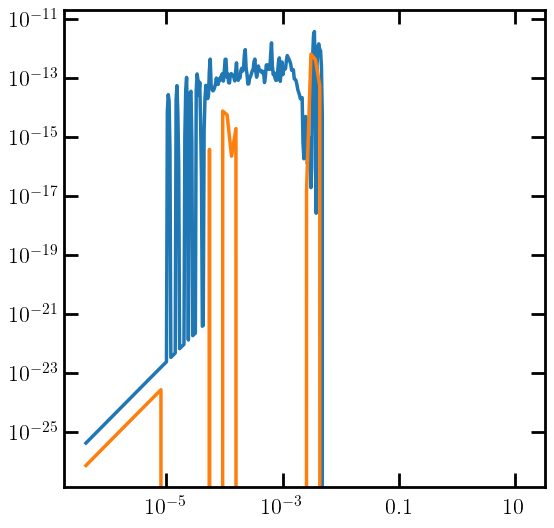

In [289]:
plt.figure()
plt.loglog()
plt.plot(hyrec100['distortion'].eng, -hyrec100['distortion'].N)
plt.plot(distortion10.eng, distortion10.N)

In [263]:
import csv

with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/EMLA.csv') as csvfile:
    reader = csv.reader(csvfile)
    EMLA_data = []
    for row in reader:
        EMLA_data.append([float(r) for r in row])
        
    EMLA_data = np.array(EMLA_data)
    
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/Recfast.csv') as csvfile:
    reader = csv.reader(csvfile)
    Rec_data = []
    for row in reader:
        Rec_data.append([float(r) for r in row])
        
    Rec_data = np.array(Rec_data)

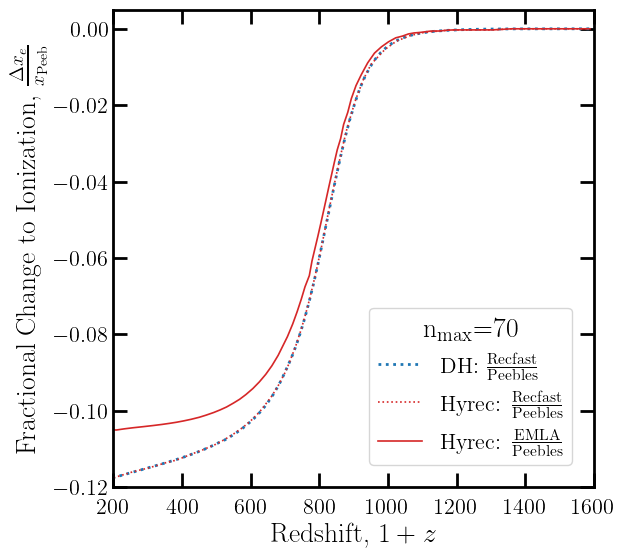

In [260]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.005])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
# plt.plot(fudge['rs'], phys.xHII_std(fudge['rs'])/baseline['x'][:,0]-1, 
#          color='C0', linestyle=':', linewidth = 2.0, 
#          label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

if False:
    plt.plot(hyrec_test10['rs'], hyrec_test10['x'][:,0]/baseline['x'][:,0]-1, 
            label=r'DH: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$, $n_{max}=10$')
    plt.plot(hyrec_test20['rs'], hyrec_test20['x'][:,0]/baseline['x'][:,0]-1, 
            label=r'$n_{max}=20$', linestyle=':')
    # plt.plot(hyrec_testfine['rs'], hyrec_testfine['x'][:,0]/baseline['x'][:,0]-1, 
    #          label=r'fine interp', linestyle=':')
    plt.plot(hyrec50['rs'], hyrec50['x'][:,0]/baseline['x'][:,0]-1, 
            label=r'$n_{max}=50$', linestyle=':')
    plt.plot(hyrec100['rs'], hyrec100['x'][:,0]/baseline['x'][:,0]-1, 
            label=r'$n_{max}=100$', linestyle=':')
    # plt.plot(hyrec10_principled['rs'], hyrec10_principled['x'][:,0]/baseline['x'][:,0]-1, 
    #          label=r'$n_{max}=50$', linestyle=':')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

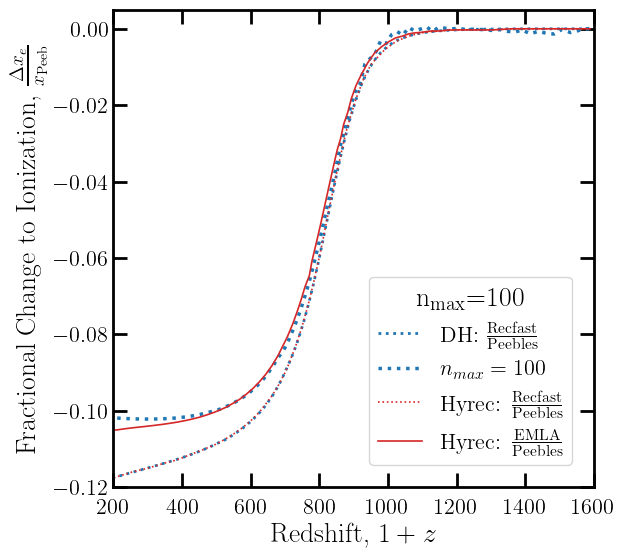

In [ ]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.005])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')

# tmp = len(hyrec_tmp['x'][::16,0])
# plt.plot(hyrec_tmp['rs'][::16], hyrec_tmp['x'][::16,0]/baseline['x'][:tmp,0]-1, 
#          label=r'$n_{max}=100$', linestyle=':')

plt.plot(hyrec_success['rs'], hyrec_success['x'][:,0]/baseline['x'][:,0]-1, 
         label=r'$n_{max}=100$', linestyle=':')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

Two mysteries to be solved:
1. Why is linear interpolation so bad?  alpha and beta vs rs look linear.  Plot the main.evolve interpolation against the above plots.
2. What's going on with the jagged features in the $\Delta x_e$ plot? (tolerance issue in odesolver)

Text(0, 0.5, 'Redshift, $1+z$')

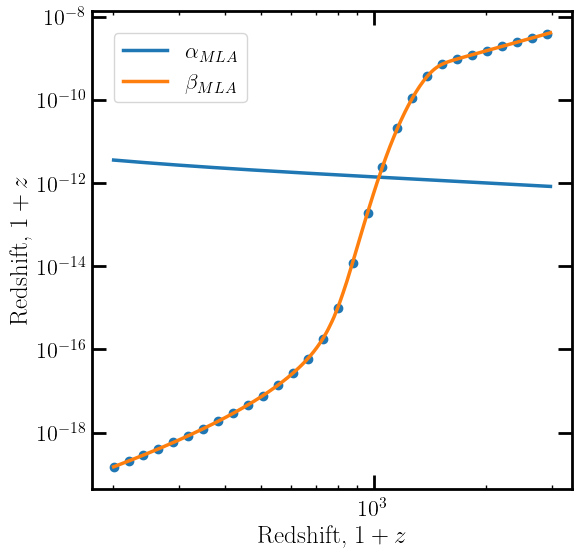

In [ ]:
plt.figure()
plt.loglog()
plt.plot(rs_vec, MLA_funcs[0](rs_vec), label=r'$\alpha_{MLA}$')
plt.plot(rs_vec, np.exp(MLA_funcs[1](np.log(rs_vec))), label=r'$\beta_{MLA}$')
plt.scatter(rs_vec[::8], np.exp(MLA_funcs[1](np.log(rs_vec[::8]))))

plt.legend()
plt.xlabel(r'Redshift, $1+z$')
plt.ylabel(r'Redshift, $1+z$')

### Maintain Plots

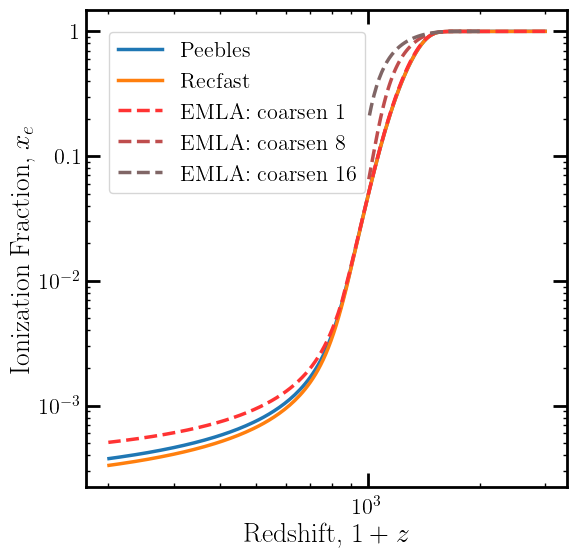

In [ ]:
plt.figure()
plt.loglog()
# plt.xlim([1.56e3,3e3])
# plt.axis([1.3e3,2e3,1e-2/5,1e-2*5])
plt.plot(baseline['rs'], baseline['x'][:,0], label='Peebles')
plt.plot(fudge['rs'], fudge['x'][:,0], label='Recfast')
plt.plot(hyrec_test['rs'], hyrec_test['x'][:,0], 
         color=(1.0,0.2,0.2), linestyle='--', label='EMLA: coarsen 1')
plt.plot(hyrec_test_coarse8['rs'], hyrec_test_coarse8['x'][:,0], 
         color=(0.75,0.3,0.3), linestyle='--', label='EMLA: coarsen 8')
plt.plot(hyrec_test_coarse16['rs'], hyrec_test_coarse16['x'][:,0], 
         color=(0.5,0.4,0.4), linestyle='--', label='EMLA: coarsen 16')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Ionization Fraction, $x_e$', fontsize=20)
plt.legend()

For the Recfast comparison:
- We have to be very careful about where the fudge factors are, since there's one explicitly in $\alpha$, one implicitly in $\beta$ since we calculate it using detailed balance on $\alpha$, and one in $\mathcal{C}$ since it uses $\beta$.  Once all of these are accounted for we get agreement, otherwise we don't.
- We must use a fudge factor of 1.14 to compare to Fig 3 of Hyrec, not our default of 1.125

In [ ]:
import csv

with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/EMLA.csv') as csvfile:
    reader = csv.reader(csvfile)
    EMLA_data = []
    for row in reader:
        EMLA_data.append([float(r) for r in row])
        
    EMLA_data = np.array(EMLA_data)
    
with open('/Users/gregoryridgway/Desktop/Webplot Digitizer/DHv2/Recfast.csv') as csvfile:
    reader = csv.reader(csvfile)
    Rec_data = []
    for row in reader:
        Rec_data.append([float(r) for r in row])
        
    Rec_data = np.array(Rec_data)

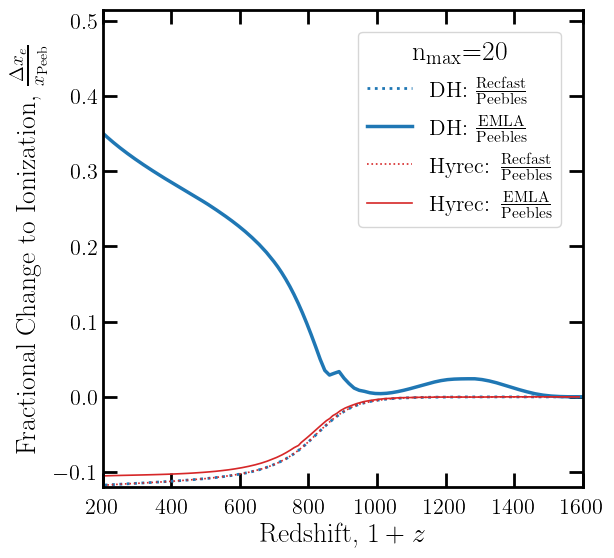

In [ ]:
plt.figure()
# plt.loglog()
# plt.xscale('log')
plt.axis([200,1600, -.12,.515])
# plt.plot(baseline['rs'], baseline['x'][:,0])
# plt.plot(baseline['rs'], phys.xHII_std(baseline['rs']))
plt.plot(fudge['rs'], fudge['x'][:,0]/baseline['x'][:,0]-1, 
         color='C0', linestyle=':', linewidth = 2.0, 
         label=r'DH: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(hyrec_test['rs'][::16], hyrec_test['x'][::16,0]/baseline['x'][:,0]-1, 
         label=r'DH: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

lw = 1.2
plt.plot(Rec_data[:,0], Rec_data[:,1], color='C3', 
         linewidth = lw, linestyle = ':', 
         label=r'Hyrec: $\frac{\mathrm{Recfast}}{\mathrm{Peebles}}$')
plt.plot(EMLA_data[:,0], EMLA_data[:,1], color='C3', 
         linewidth = lw, linestyle = 'solid', 
         label=r'Hyrec: $\frac{\mathrm{EMLA}}{\mathrm{Peebles}}$')

plt.xlabel(r'Redshift, $1+z$', fontsize=20)
plt.ylabel(r'Fractional Change to Ionization, $\frac{\Delta x_e}{x_{\mathrm{Peeb}}}$', fontsize=20)
# plt.ylabel(r'Occupation Number', fontsize=20)
plt.legend(title=r'$\mathrm{n_{max}}$='+str(nmax))

# plt.title(r'Testing the TLA Assumptions')

## Trying to fix the ODE solver

In [ ]:
from scipy.integrate import odeint

In [ ]:
def compton_cooling_rate(xHII, T_m, rs):
    xe = xHII

    return (
        4 * phys.thomson_xsec * 4 * phys.stefboltz / phys.me
        * xe * phys.nH*rs**3 * (phys.TCMB(rs) - T_m)
        * phys.TCMB(rs)**4
    )

In [ ]:
MLA_switch = False

if not MLA_switch:
    def beta_tmp(*args):
        rs, xe, Tm = args

        tau = atomic.tau_np_1s(2,rs)
        x2s = atomic.x2s_steady_state(rs, phys.TCMB(rs), Tm, xe, 1-xe, tau)
        x2  = 4*x2s
        beta_ion = phys.beta_ion(Tm, 'HI')

        return beta_ion * x2

    def alpha_tmp(*args):
        Tm, = args
        return phys.alpha_recomb(Tm, 'HI')
    
else:
    kind='linear'
    
    alpha_tmp = interp1d(rs_vec, alpha_MLA, kind=kind, fill_value='extrapolate')
    beta_tmp  = interp1d(rs_vec, beta_MLA, kind=kind)

Try Saha, then TLA, then MLA

In [ ]:
import warnings

rs_div = 1.6e3

def tmp_tla(rs_vec, init, alpha_tmp, beta_tmp, mxstep=1000, rtol=1e-3):
    
    def xHII(yHII):
        return 0.5 + 0.5*np.tanh(yHII)

    def derivs(rs, var):
        nH = phys.nH*rs**3

        def dlogT_dz(yHII, log_T_m, rs):

            T_m, xe = np.exp(log_T_m), xHII(yHII)
            xHI = 1 - xHII(yHII)
            
            xe = phys.xHII_std(rs)

            adiabatic_cooling_rate = 2 * T_m/rs

            return 1 / T_m * adiabatic_cooling_rate + 1 / T_m * (
                phys.dtdz(rs)*(
                    compton_cooling_rate(
                        xHII(yHII), T_m, rs
                    )
                )
            )/ (3/2 * nH * (1 + phys.chi + xe))

        def dyHII_dz(yHII, log_T_m, rs):

            T_m, xe = np.exp(log_T_m), xHII(yHII)

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                return 0

            if xHII(yHII) > 0.99 and rs > rs_div:
                # Use the Saha value. 
                return 2 * np.cosh(yHII)**2 * phys.d_xe_Saha_dz(rs, 'HI')

            ne = xe * nH
            xHI = 1 - xHII(yHII)
            
            

            if not MLA_switch:
#                 print(rs, alpha_tmp(T_m) * xHII(yHII) * xe * nH, 
#                       beta_tmp(rs, xe, T_m))
                return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                    -(alpha_tmp(T_m) * xHII(yHII) * xe * nH - beta_tmp(rs, xe, T_m))
                )
            else:
                
#                 print(rs, alpha_tmp(rs), beta_tmp(rs))
                return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
                    -(alpha_tmp(rs) * xHII(yHII) * xe * nH - beta_tmp(rs))
                )
                
#                 with warnings.catch_warnings():
#                     warnings.filterwarnings('error')
#                     try:
#                         return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
#                             -(alpha_tmp(rs) * xHII(yHII) * xe * nH - beta_tmp(rs))
#                         )
#                     except RuntimeWarning:
#                         print(rs, yHII)
#                         return 2 * np.cosh(yHII)**2 * phys.dtdz(rs) * (
#                             -(alpha_tmp(rs) * xHII(yHII) * xe * nH - beta_tmp(rs))
#                         )
                    

        log_T_m, yHII = var[0], var[1]
        
#         print(rs, 
#               dlogT_dz(yHII, log_T_m, rs),
#              dyHII_dz(yHII, log_T_m, rs)
#         )

        return [
            dlogT_dz(yHII, log_T_m, rs),
            dyHII_dz(yHII, log_T_m, rs)
        ]

    if MLA_switch: print('MLA')
    else: print('TLA')

    
    soln = odeint(
        derivs, init, rs_vec,
        mxstep = mxstep, tfirst=True, rtol=rtol
    )

    soln[:,0] = np.exp(soln[:,0])
    soln[:,1] = xHII(soln[:,1])

    return soln
        
    if False:
        
        print('MLA')
        
        # Number of attempts before giving up. 
        N_attempts = 0
        # Flag to determine if solution was reached.
        solved = False

        # List of indices (m_m, Q) where the solution failed. 
        error_arr = [] 

        while (not solved) and (N_attempts < 10):
            # Keep attempting until solved or we've tried twice. 

            try:

                # Solve using solve_ivp. 
                soln = solve_ivp(
                    derivs, [rs_vec[0], rs_vec[-1]], init_cond, 
                    method='LSODA', t_eval=rs_vec, 
                    rtol=rtol, max_step= mxstep
                )

            except:
                # solve_ivp returned an error. Adjust the tolerance
                # and step size and try again. 

                rtol /= 1.2
                mxstep /= 1.5

            else:
                # solve_ivp completed successfully. However, we still need to check
                # that the solution managed to integrate over the entire redshift range,
                # and that there are no NaNs in the solution.
                if soln['t'].size == rs_vec.size and not np.isnan(soln['y']).any():
                    solved = True
                else:
                    N_attempts += 1
                    print('TRY AGAIN: try', N_attempts)

        if not solved:
            # If solution fails, simply return False. 
            soln = False
            print('NOT SOLVED')
        else:
            new_soln = np.zeros((len(soln['y'][0]), 2))
            new_soln[:,0] = np.exp(soln['y'][0])
            new_soln[:,1] = xHII(soln['y'][1])
            return new_soln

In [ ]:
rs_list = np.logspace(np.log10(3e3),np.log10(1e2), 100)

# rs_list = np.logspace(np.log10(rs_div),np.log10(1e2), 100)

start_rs = rs_list[0]
init_cond = np.array([
    np.log(phys.Tm_std(start_rs)), 
    np.arctanh(2*(phys.xHII_std(start_rs) - 0.5))
])

In [ ]:
soln = tmp_tla(rs_list, init_cond, alpha_tmp, beta_tmp, rtol=1e-3)

if MLA_switch:
    soln_MLA = soln
else:
    soln_TLA = soln

MLA


In [ ]:
soln = tmp_tla(rs_list, init_cond, alpha_tmp, beta_tmp, rtol=1e-5)

if MLA_switch:
    soln_MLA = soln
else:
    soln_TLA = soln

TLA


Try printing out the dxde's to see that the values are reasonable

Try changing the step size at the discontinuity

Is there a built in function telling me where this overflow is coming from

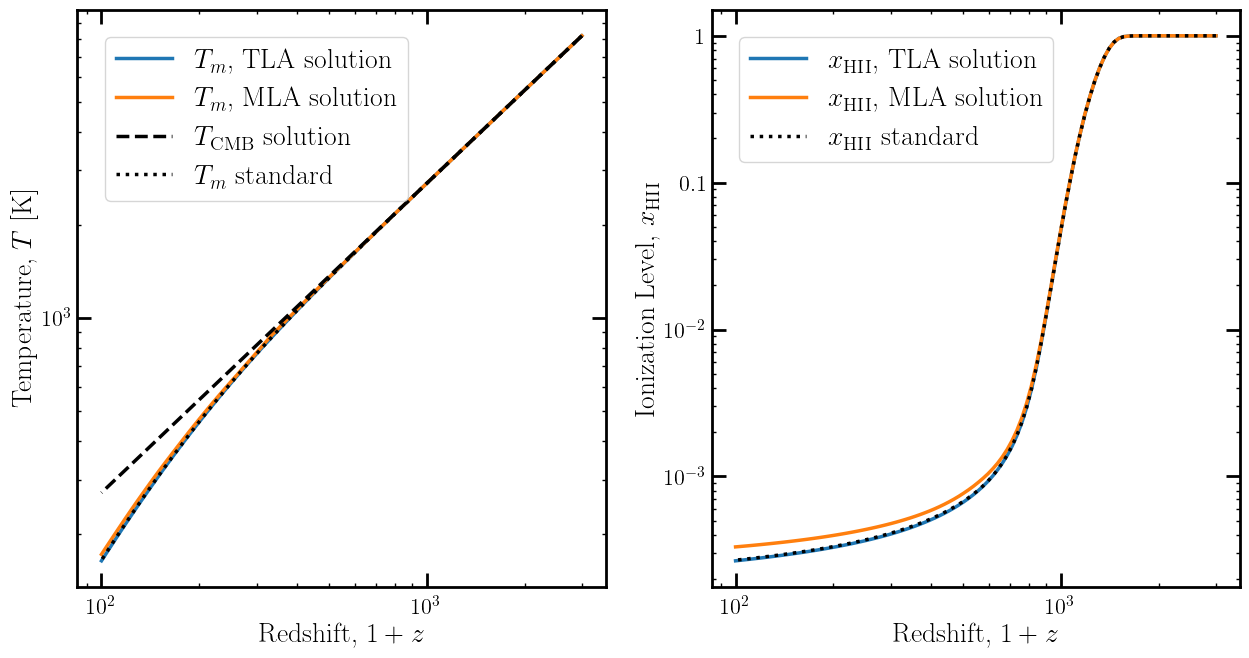

In [ ]:
fig, axarr = plt.subplots(1, 2, figsize=(2*7.5, 7.5))


#----- Fig 1 ----#
axarr[0].loglog()
axarr[0].plot(rs_list, soln_TLA[:,0]/phys.kB, label=r'$T_m$, TLA solution')
axarr[0].plot(rs_list, soln_MLA[:,0]/phys.kB, label=r'$T_m$, MLA solution')

axarr[0].plot(rs_list, phys.TCMB(rs_list)/phys.kB, 
              color='k', linestyle='--', label=r'$T_{\mathrm{CMB}}$ solution')
axarr[0].plot(rs_list, phys.Tm_std(rs_list)/phys.kB, 
              color='k', linestyle=':', label=r'$T_m$ standard')
axarr[0].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[0].set_ylabel(r'Temperature, $T$ [K]', fontsize=20)
axarr[0].legend(fontsize=20)
#----------------#
#----------------#



#----- Fig 2 ----#
axarr[1].loglog()
axarr[1].plot(rs_list, soln_TLA[:,1], label=r'$x_{\mathrm{HII}}$, TLA solution')
axarr[1].plot(rs_list, soln_MLA[:,1], label=r'$x_{\mathrm{HII}}$, MLA solution')

axarr[1].plot(rs_list, phys.xHII_std(rs_list), 
              color='k', linestyle=':', label=r'$x_{\mathrm{HII}}$ standard')
axarr[1].set_xlabel(r'Redshift, $1+z$', fontsize=20)
axarr[1].set_ylabel(r'Ionization Level, $x_{\mathrm{HII}}$', fontsize=20)
axarr[1].legend(fontsize=20)

# axarr[1].axvline(rs_div, color='k', linestyle=':')
#----------------#
#----------------#

In [ ]:
ind1=5

start_rs = rs_vec[-ind1]
data=np.zeros((length-(ind1-1),2))
data[-1] = np.array([
    np.log(phys.Tm_std(start_rs)), 
    np.arctanh(2*(phys.xHII_std(start_rs) - 0.5))
])

lim = 5
for k in np.arange(lim):
    x2 = x2_vec[-ind1-k]
    Tr = Tr_vec[-ind1-k]
    Tm = Tm_vec[-ind1-k]
    
    beta_tmp  = phys.beta_ion(Tr,'HI') * x2
    alpha_tmp = phys.alpha_recomb(Tm, 'HI')/1.125
    
    rs_diff = rs_vec[-ind1-k:-ind1-(k+2):-1]
    
    soln = tmp_tla(rs_diff, data[-1-k], alpha_tmp, beta_tmp)
    
    data[-2-k] = soln[-1]
    
data[:,0] = np.exp(data[:,0])/phys.kB
data[:,1] = 0.5 + 0.5*np.tanh(data[:,1])

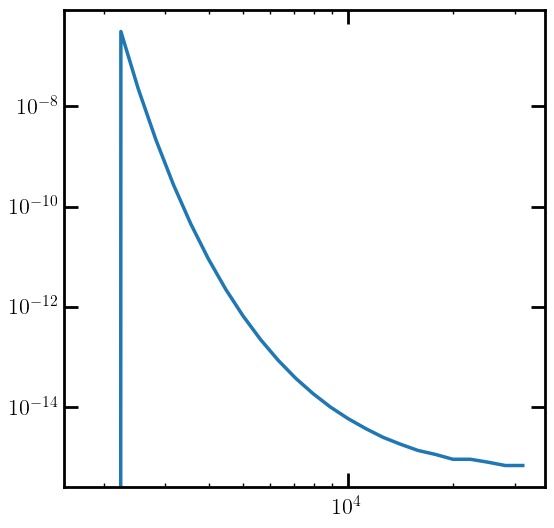

In [ ]:
plt.figure()
plt.loglog()
plt.plot(rs_vec[-1-lim:], 1-data[-1-lim:,1])


# Distortion

In [ ]:
%autoreload
mDM = 3e10
# sigmav = xsec_bound_elec_CMB(mDM,'swave')
tau=1e25
species = 'elec'
DM_process = 'decay'
string = str(int(np.floor(np.log10(mDM))))
test_main = main.evolve(
    DM_process=DM_process, mDM=mDM,
    lifetime=tau,
    primary=species+'_delta',
    start_rs = 3e3,
    coarsen_factor=12, backreaction=False, distort=False,
#     struct_boost=struct_boost,
    end_rs=2.5e3
)

In [ ]:
spec10  = test_main['highengphot'][-1]
spec10.redshift(1)

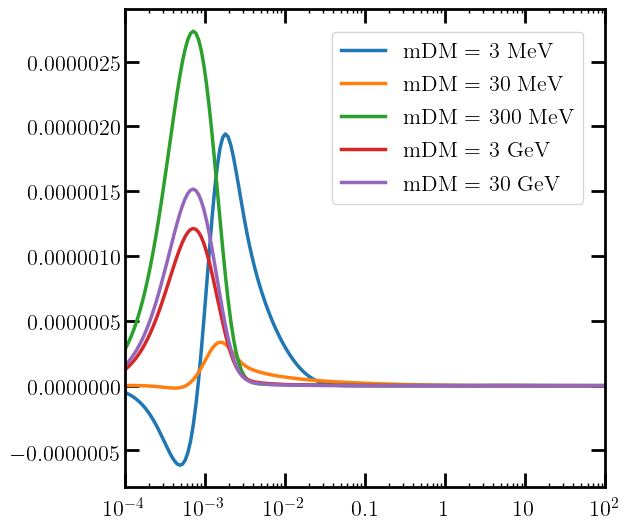

In [ ]:
plt.figure()
plt.xscale('log')
plt.xlim([1e-4,100])
plt.plot(spec6.eng, spec6.eng*spec6.dNdE, label='mDM = 3 MeV')
plt.plot(spec.eng, spec.eng*spec.dNdE, label='mDM = 30 MeV')
plt.plot(spec8.eng, spec8.eng*spec8.dNdE, label='mDM = 300 MeV')
plt.plot(spec9.eng, spec9.eng*spec9.dNdE, label='mDM = 3 GeV')
plt.plot(spec10.eng, spec10.eng*spec10.dNdE, label='mDM = 30 GeV')
plt.legend()

$$
I =  \frac{h c E}{4 \pi} \frac{dn}{dE}
$$

In [ ]:
hplanck = phys.hbar * 2 * np.pi

nu_range = np.logspace(-1,np.log10(1.75e12), 100)
eng_range = hplanck * nu_range

(10000000.0, 10000000000000.0, 1e-24, 1e-17)

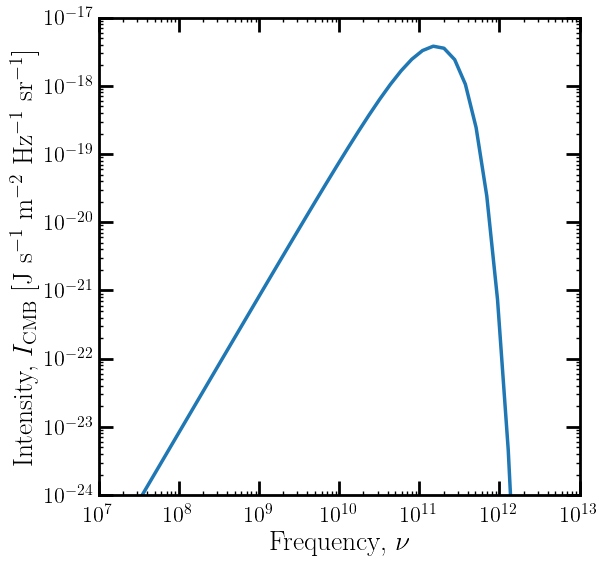

In [320]:
hplanck = phys.hbar * 2 * np.pi

nu_range = np.logspace(-1,np.log10(1.75e12), 100)
eng_range = hplanck * nu_range

dNdE = phys.CMB_spec(eng_range, phys.TCMB(1))
convert = eng_range * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4


plt.figure()
plt.loglog()

plt.plot(nu_range, convert * dNdE)
plt.xlabel(r'Frequency, $\nu$', fontsize=20)
plt.ylabel(r'Intensity, $I_{\mathrm{CMB}}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
plt.axis([1e7, 1e13, 1e-24, 1e-17])